# Network Causality : Model-free Inference

**Content creator**: Kai Chen

# Tutorial Objectives

In this notebook, we'll start to explore some of the model-free inference methods. More importantly, we gonna to compare performances of those methods. 

1. Introduction to time-delayed mutual informaiton.
1. Causal inference in linear and nonlinear systems.
1. Causal inference for experimental data.


#### References:
- D. Zhou, Y. Xiao, Y. Zhang, Z. Xu and D. Cai, “Granger causality network reconstruction of conductance-based integrate-and-fire neuronal systems”, PLoS ONE, 9 (2), e87636, 2014. ([PDF](https://ins.sjtu.edu.cn/people/zdz/publication_papers/Granger_Causality_Reconstruction.pdf))
- S. Li, Y. Xiao, D. Zhou and D. Cai, “Causal inference in nonlinear systems: Granger causality versus time-delayed mutual information”, Phys. Rev. E, 97 (5), 052216, 2018. ([PDF](https://ins.sjtu.edu.cn/people/zdz/publication_papers/Granger_causality_versus_time_delayed_mutual_information.pdf))
- Matlab-based fast GC-estimator: [GC_clean](https://github.com/bewantbe/GC_clean)
- Python-based mutual-information estimator: [mutual-information](https://github.com/NeoNeuron/mutual_information)
- SciPy $\chi^2$ statistics [documents](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.chi2.html).

---
# Setup

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from scipy.stats import chi2

In /Users/kchen/.matplotlib/stylelib/dark.mplstyle: 
The animation.avconv_args rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /Users/kchen/.matplotlib/stylelib/dark.mplstyle: 
The animation.avconv_path rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /Users/kchen/.matplotlib/stylelib/dark.mplstyle: 
The animation.html_args rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /Users/kchen/.matplotlib/stylelib/dark.mplstyle: 
The keymap.all_axes rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /Users/kchen/.matplotlib/stylelib/dark.mplstyle: 
The mathtext.fallback_to_cm rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /Users/kchen/.matplotlib/stylelib/dark.mplstyle: Support for setting the 'mathtext.fallback_to_cm' rcParam is deprecated since 3.3 and will be removed two minor releases lat

In [2]:
#@title Figure settings
import ipywidgets as widgets       # interactive display
%config InlineBackend.figure_format = 'retina'
# plt.style.use("https://raw.githubusercontent.com/NeoNeuron/professional-workshop-3/master/nma.mplstyle")

In [3]:
# @title Helper functions

def create_structure_array(x:np.ndarray, order:int)->np.ndarray:
    '''
    Prepare structure array for regression analysis.
    
    Args:
    x         : original time series
    order     : regression order
    
    Return:
    x_array   : structure array with shape (len(x)-order) by (order).
    
    '''
    N = len(x) - order
    x_array = np.zeros((N, order))
    for i in range(order):
        x_array[:, i] = x[-i-1-N:-i-1]
    return x_array

def auto_reg(x, order)->np.ndarray:
    '''
    Auto regression analysis of time series.
    
    Args:
    x         : original time series
    order     : regression order
    
    Return:
    res       : residual vector
    
    '''
    reg_array = create_structure_array(x, order)
    coef = np.linalg.lstsq(reg_array, x[order:], rcond=None)[0]
    res = x[order:] - reg_array @ coef
    return res

def joint_reg(x, y, order)->np.ndarray:
    '''
    Joint regression analysis of time series.
    
    Args:
    x         : original time series 1
    y         : original time series 2
    order     : regression order
    
    Return:
    res       : residual vector
    
    '''
    reg_array_x = create_structure_array(x, order)
    reg_array_y = create_structure_array(y, order)
    reg_array = np.hstack((reg_array_x, reg_array_y))
    coef = np.linalg.lstsq(reg_array, x[order:], rcond=None)[0]
    res = x[order:] - reg_array @ coef
    return res

def GC(x, y, order):
    '''
    Granger Causality from y to x
    
    Args:
    x         : original time series (dest)
    y         : original time series (source)
    order     : regression order
    
    Return:
    GC_value  : residual vector
    
    '''
    res_auto = auto_reg(x, order)
    res_joint = joint_reg(x, y, order)
    GC_value = 2.*np.log(res_auto.std()/res_joint.std())
    return GC_value
    
def GC_SI(p, order, length):
    '''
    Significant level of GC value.
    
    Args
    p       : p-value
    order   : parameter of chi^2 distribution
    length  : length of data.
    
    Return:
    significant level of null hypothesis (GC 
        between two independent time seies)
    
    '''
    return chi2.ppf(1-p, order)/length

# Section 1: Time-delayed Mutual Information (TDMI)

TDMI is an information-theoretic approach for detecting causal interactions. In general, the quantity of mutual information characterizes the common information shared between two signals. Given two stationary signals X and Y with their time traces {$x_t$} and {$y_t$}, respectively, the mutual information between them is defined as
$$
I(X, Y)=\sum_{x_{t}} \sum_{y_t} p\left(x_{t}, y_{t}\right) \log \frac{p\left(x_{t}, y_{t}\right)}{p\left(x_{t}\right) p\left(y_{t}\right)}
$$
where $ p(xt ,yt )$ is the joint probability distribution of $X = x_t$ and $Y = y_t$ , $p(x_t)$ and $p(y_t)$ are their marginal probability distributions. In particular, $I (X,Y) = 0$ is equivalent to $p(x_t ,y_t) = p(x_t)p(y_t)$, which indicates that signals $X$ and $Y$ are independent if they do not share information.

Mutual information is symmetric, i.e., $I (X,Y ) = I (Y,X)$. Therefore, it cannot be applied directly to infer the direction of interactions between two signals. To overcome this limitation, one can introduce a time-lag parameter $\tau$ to capture the delay of information transfer between the two signals. TDMI as a function of time-lag $\tau$ is defined as

$$
I(X, Y, \tau)=\sum_{x_{t}} \sum_{y_{t-\tau}} p\left(x_{t}, y_{t-\tau}\right) \log \frac{p\left(x_{t}, y_{t-\tau}\right)}{p\left(x_{t}\right) p\left(y_{t-\tau}\right)}
$$

where $p(x_t ,y_{t −\tau} )$ is the joint probability distribution of $X = x_t$ and $Y = y_{t −\tau}$ . A nonzero amplitude of the mutual information as a function of $\tau$ indicates the existence of interactions between two signals; the sign of the time-lag $\tau$ where $I(X,Y,\tau)$ reaches its peak magnitude is used to infer the information flow direction that can be further interpreted as the causal direction of interaction. A negative $\tau$ indicates that $X$ shares a maximum amount of information with the future of $Y$ , thus $X$ drives $Y$. A positive $\tau$ indicates that $X$ shares a maximum amount of information with the past of $Y$, thus $X$ is driven by $Y$ .

In [4]:
# Add you code to estimate mutual information
def mi(x, y, bins = None):
    """mutual information for 0-1 binary time series
    :param x: first series
    :type x: int of ndarray
    :param y: second series
    :type y: int of ndarray
    :return: mutual information

    """
    N = len(x)
    if bins is None:
        bins = np.sqrt(N).astype(int)
    pxy,_,_ = np.histogram2d(x, y, bins)
    pxx = np.tile(pxy.sum(1), (bins, 1)).T
    pyy = np.tile(pxy.sum(0), (bins, 1))
    mask = pxy!=0
    mi_val = np.sum(pxy[mask]*np.log(pxy[mask]/pxx[mask]/pyy[mask]))
    return mi_val / N + np.log(N) 

def dmi(x, y, delay):
    if delay == 0:
        return mi(x, y)
    elif delay < 0:
        return mi(x[-delay:],y[:delay])
    elif delay > 0:
        return mi(x[:-delay],y[delay:])

def tdmi(x, y, time_range):
    return np.array([dmi(x,y,delay) for delay in time_range])

#### [Python code for mutual information estimation](https://github.com/NeoNeuron/mutual_information)

In [5]:
# install minfo, a Cython-based mutual information estimator;
!pip install minfo

In [6]:
# import mutual information estimator
from minfo.mi_float import tdmi_omp
# wrap funciotns estimating time-delayed mutual information
def TDMI(x:np.ndarray, y:np.ndarray, time_range:np.ndarray) -> np.ndarray:

    assert 0 in delay
    assert time_range.dtype == int

    tdmi_val = np.zeros_like(time_range, dtype=float)
    pos_end = np.max(time_range).astype(int)
    neg_end = -np.min(time_range).astype(int)
    if neg_end == 0:
        tdmi_val = tdmi_omp(x, y, pos_end+1)
    elif pos_end == 0:
        tdmi_val = np.flip(tdmi_omp(y, x, neg_end+1))
    else:
        tdmi_val[neg_end:] = tdmi_omp(x, y, pos_end+1)
        tdmi_val[:neg_end+1] = np.flip(tdmi_omp(y, x, neg_end+1))
    
    return tdmi_val

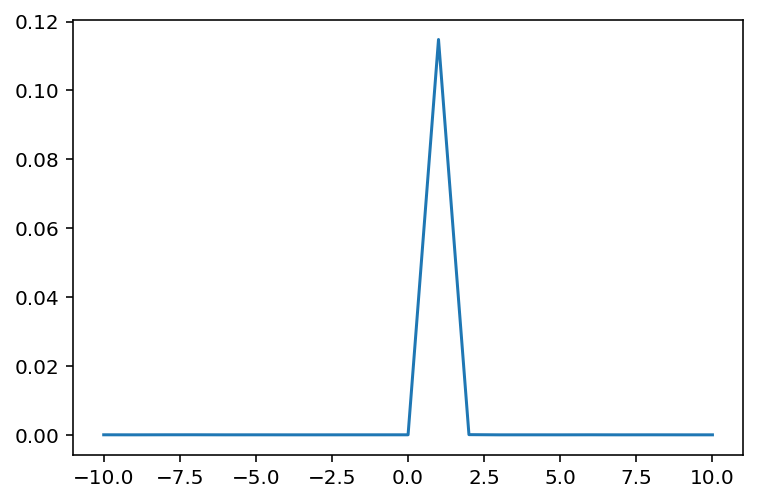

In [7]:
# test TDMI()
test_x = np.random.randn(100000)
test_y = np.random.randn(100000)
test_y[1:] += test_x[:-1]*0.5
delay = np.arange(21)-10
plt.plot(delay, TDMI(test_x, test_y, delay))

---
# Section 2: Causal inference in linear and nonlinear systems.

Now use these two methods you code above to play with few artifitially generated time series.

## Case A: Unidirection misinferred as no interaction
\begin{array}{l}x_{t}=\varepsilon_{t} \\ y_{t}=-0.1 x_{t-1}+\eta_{t}\end{array}

In [8]:
def system_A(length):
    x = np.random.randn(length)
    y = np.random.randn(length)
    y[1:] += -0.1*x[:-1]
    return x, y

In [9]:
# GC version
length = int(1e7)
order = 10
X, Y = system_A(length)
print(f'GC Y->X     : {GC(X, Y, order):.3e}')
print(f'GC X->Y     : {GC(Y, X, order):.3e}')
print(f'GC threshold: {GC_SI(0.001, order, length):.3e}')


GC Y->X     : 1.341e-06
GC X->Y     : 9.955e-03
GC threshold: 2.959e-06


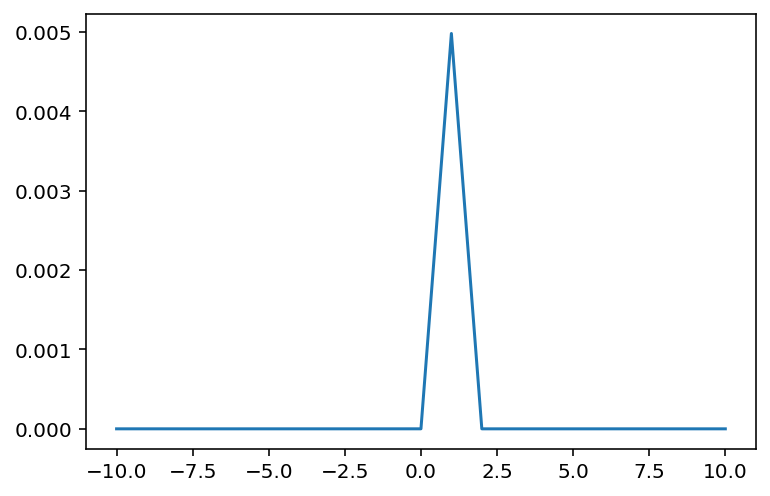

In [10]:
# TDMI version
delay = np.arange(21)-10
plt.plot(delay, TDMI(X,Y,delay))

### Nonlinear transformation
$$
\tilde{x}_t = x_t^2
$$

In [11]:
# GC version
X_tilde = X**2
print(f'GC Y->X     : {GC(X_tilde, Y, order):.3e}')
print(f'GC X->Y     : {GC(Y, X_tilde, order):.3e}')
print(f'GC threshold: {GC_SI(0.001, order, length):.3e}')

GC Y->X     : 5.612e-07
GC X->Y     : 2.389e-07
GC threshold: 2.959e-06


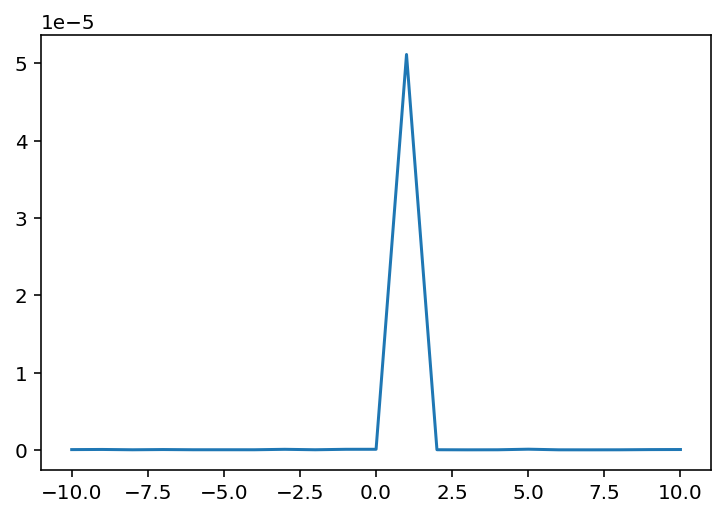

In [12]:
# TDMI version
delay = np.arange(21)-10
plt.plot(delay, TDMI(X_tilde,Y,delay))

## Case B: Unidirection misinferred as bidirection
\begin{array}{l}x_{t}=-0.3 x_{t-1}+\varepsilon_{t} \\ y_{t}=0.3 y_{t-1}-0.9 x_{t-1}+\eta_{t}\end{array}

In [13]:
def system_B(length):
    x = np.random.randn(length)
    y = np.random.randn(length)
    for i in range(1, length):
        x[i] += -0.3*x[i-1]
        y[i] += 0.3*y[i-1] - 0.9*x[i-1]
    return x, y

In [14]:
# GC version
length = int(1e7)
order = 10
X, Y = system_B(length)
print(f'GC Y->X     : {GC(X, Y, order):.3e}')
print(f'GC X->Y     : {GC(Y, X, order):.3e}')
print(f'GC threshold: {GC_SI(0.001, order, length):.3e}')


GC Y->X     : 5.059e-07
GC X->Y     : 6.154e-01
GC threshold: 2.959e-06


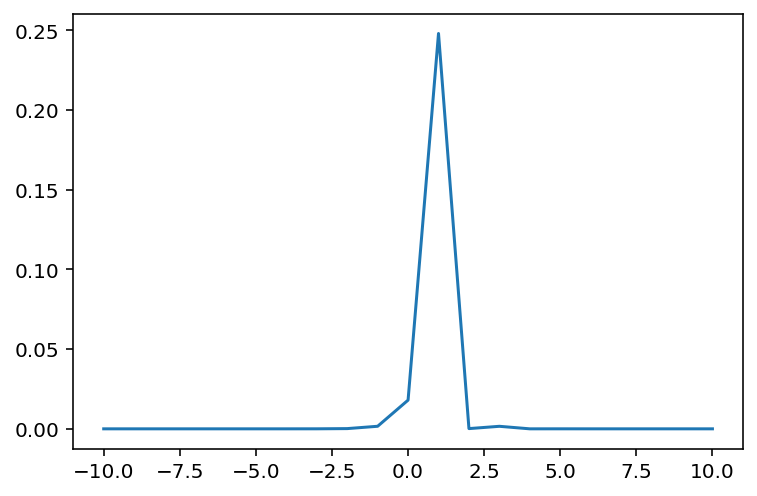

In [15]:
# TDMI version
delay = np.arange(21)-10
plt.plot(delay, TDMI(X,Y,delay))

### Nonlinear transformation
$$
\tilde{x}_t = \left[\frac{x_t+|x_t|}{2}\right]^5
$$

In [16]:
# GC version
X_tilde = ((X+np.abs(X))/2)**5
print(f'GC Y->X     : {GC(X_tilde, Y, order):.3e}')
print(f'GC X->Y     : {GC(Y, X_tilde, order):.3e}')
print(f'GC threshold: {GC_SI(0.001, order, length):.3e}')


GC Y->X     : 2.490e-04
GC X->Y     : 5.728e-02
GC threshold: 2.959e-06


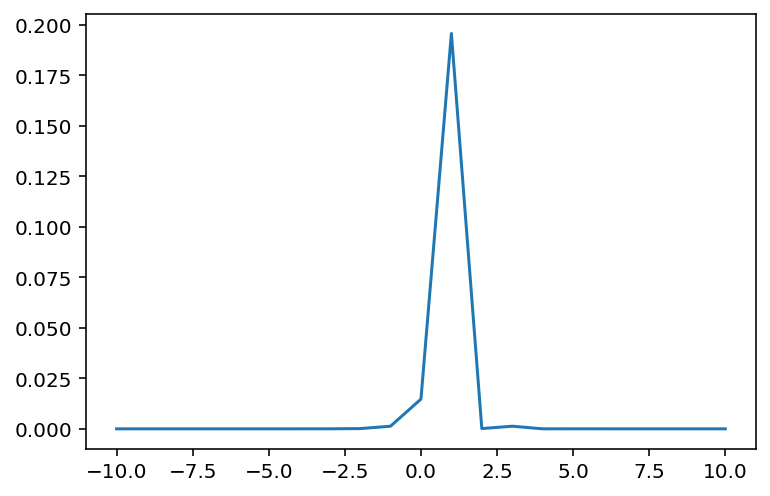

In [17]:
# TDMI version
delay = np.arange(21)-10
plt.plot(delay, TDMI(X_tilde,Y,delay))

## Case C: Unidirection misinferred as reversed unidirection
\begin{aligned}
&x_{t}=-\sum_{k=1}^{8} c_{k} x_{t-k}+\varepsilon_{t} \\
&y_{t}=-\sum_{k=1}^{8} c_{k} y_{t-k}+100 \sum_{k=1}^{9} c_{k-1} x_{t-k}+\eta_{t}
\end{aligned}

In [18]:
def system_C(length):
    x = np.random.randn(length) * 2.27e-3
    y = np.random.randn(length)
    c_coef = np.array([-5.1777,12.6133,-18.6167,18.1332,-11.9147,5.1664,-1.3573,0.1678])
    
    return x, y

In [19]:
# GC version
length = int(1e7)
order = 10
X, Y = system_C(length)
print(f'GC Y->X     : {GC(X, Y, order):.3e}')
print(f'GC X->Y     : {GC(Y, X, order):.3e}')
print(f'GC threshold: {GC_SI(0.001, order, length):.3e}')

GC Y->X     : 1.821e-06
GC X->Y     : 8.585e-07
GC threshold: 2.959e-06


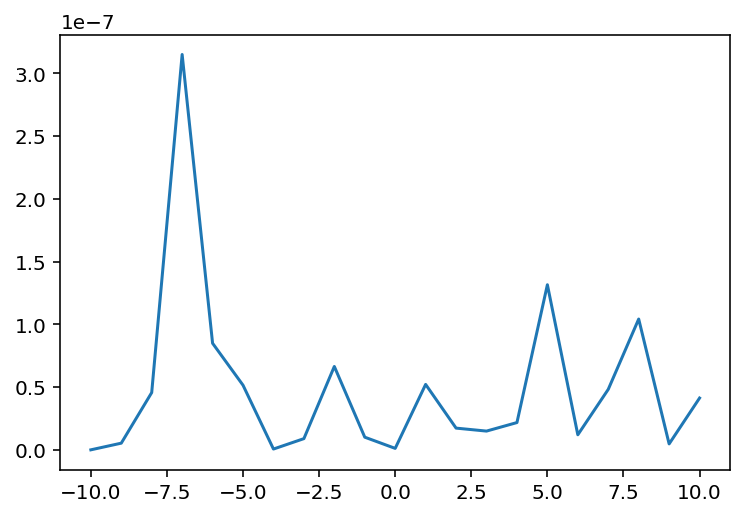

In [20]:
# TDMI version
delay = np.arange(21)-10
plt.plot(delay, TDMI(X,Y,delay))

### Nonlinear transformation
$$
\tilde{x}_t = x_t^5
$$

In [21]:
# GC version
X_tilde = X**5
print(f'GC Y->X     : {GC(X_tilde, Y, order):.3e}')
print(f'GC X->Y     : {GC(Y, X_tilde, order):.3e}')
print(f'GC threshold: {GC_SI(0.001, order, length):.3e}')

GC Y->X     : 1.200e-07
GC X->Y     : 0.000e+00
GC threshold: 2.959e-06


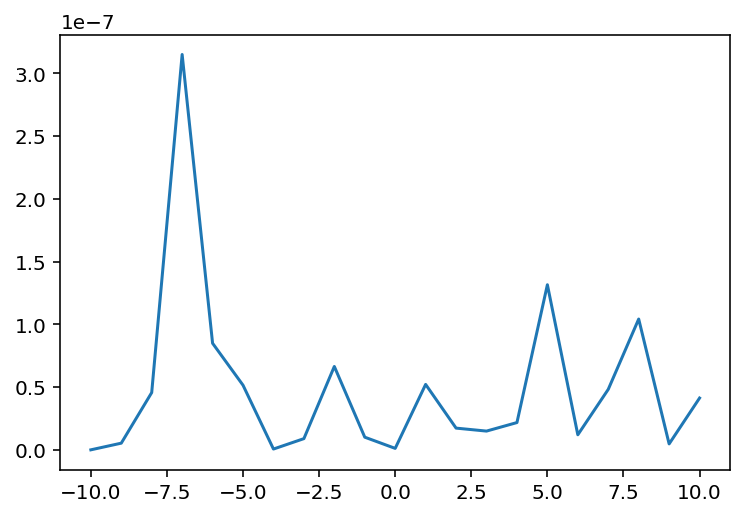

In [22]:
# TDMI version
delay = np.arange(21)-10
plt.plot(delay, TDMI(X_tilde,Y,delay))

## Case D: Bidirection misinferred as no interaction
\begin{array}{l}x_{t}=-0.1 y_{t-1}+\varepsilon_{t} \\ y_{t}=-0.1 x_{t-1}+\eta_{t}\end{array}

In [23]:
def system_D(length):
    x = np.random.randn(length)
    y = np.random.randn(length)
    for i in range(1, length):
        x[i] += -0.1*y[i-1]
        y[i] += -0.1*x[i-1]
    return x, y

In [24]:
# GC version
length = int(1e7)
order = 10
X, Y = system_D(length)
print(f'GC Y->X     : {GC(X, Y, order):.3e}')
print(f'GC X->Y     : {GC(Y, X, order):.3e}')
print(f'GC threshold: {GC_SI(0.001, order, length):.3e}')

GC Y->X     : 9.938e-03
GC X->Y     : 9.891e-03
GC threshold: 2.959e-06


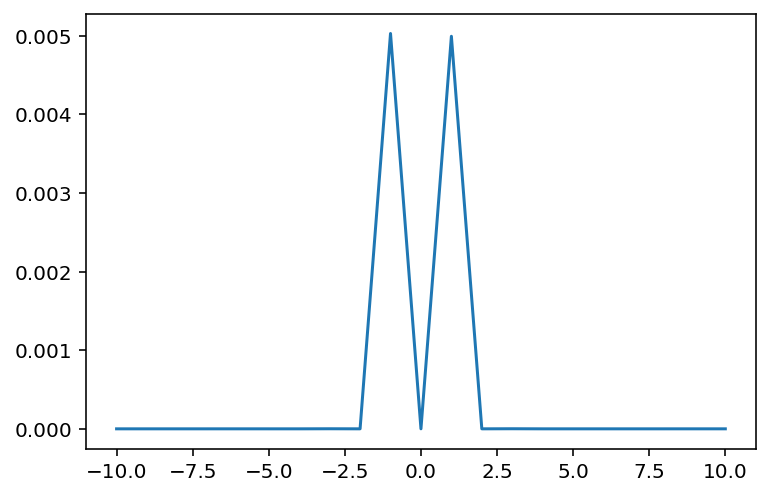

In [25]:
# TDMI version
delay = np.arange(21)-10
plt.plot(delay, TDMI(X,Y,delay))

### Nonlinear transformation
$$
\tilde{x}_t = x_t^2
$$

In [26]:
# GC version
X_tilde = X**2
print(f'GC Y->X     : {GC(X_tilde, Y, order):.3e}')
print(f'GC X->Y     : {GC(Y, X_tilde, order):.3e}')
print(f'GC threshold: {GC_SI(0.001, order, length):.3e}')

GC Y->X     : 8.505e-07
GC X->Y     : 5.651e-07
GC threshold: 2.959e-06


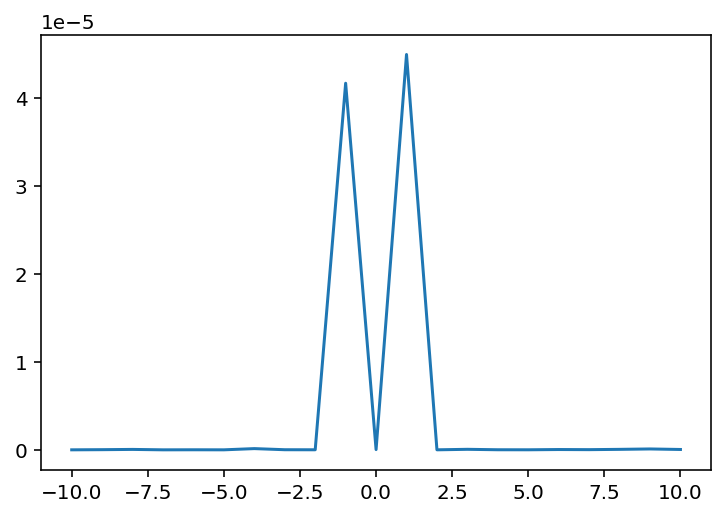

In [27]:
# TDMI version
delay = np.arange(21)-10
plt.plot(delay, TDMI(X_tilde,Y,delay))

## Case E: Bidirection misinferred as unidirection
\begin{aligned}
x_{t}=-\sum_{k=1}^{8} c_{k} x_{t-k}+0.5 \sum_{k=1}^{9} c_{k-1} y_{t-k}+\varepsilon_{t} \\
y_{t}=-\sum_{k=1}^{8} c_{k} y_{t-k}+0.5 \sum_{k=1}^{9} c_{k-1} x_{t-k}+\eta_{t}
\end{aligned}
$$
x_{t}=-\sum_{k=1}^{8} c_{k} x_{t-k}+0.5 \sum_{k=1}^{9} c_{k-1} y_{t-k}+\varepsilon_{t} \\
y_{t}=-\sum_{k=1}^{8} c_{k} y_{t-k}+0.5 \sum_{k=1}^{9} c_{k-1} x_{t-k}+\eta_{t}
$$

In [28]:
def system_E(length):
    x = np.random.randn(length)
    y = np.random.randn(length)
    for i in range(1, length):
        # Add your code here
        pass
    return x, y

In [29]:
# GC version
# length = int(1e2)
# order = 10
# X, Y = system_E(length)
# print(f'GC Y->X     : {GC(X, Y, order):.3e}')
# print(f'GC X->Y     : {GC(Y, X, order):.3e}')
# print(f'GC threshold: {GC_SI(0.001, order, length):.3e}')

In [30]:
# TDMI version
# delay = np.arange(21)-10
# plt.plot(delay, TDMI(X,Y,delay))

### Nonlinear transformation
$$
\tilde{x}_t = \tanh(10x_t)
$$

In [31]:
# GC version
# X_tilde = np.tanh(10*X)
# print(f'GC Y->X     : {GC(X_tilde, Y, order):.3e}')
# print(f'GC X->Y     : {GC(Y, X_tilde, order):.3e}')
# print(f'GC threshold: {GC_SI(0.001, order, length):.3e}')

In [32]:
# TDMI version
# delay = np.arange(21)-10
# plt.plot(delay, TDMI(X_tilde,Y,delay))

# Summary Table

![](./static/summary_table.png)

---
# Section 3: Interactions between neuronal signals

In [33]:
from scipy.io import loadmat
data = loadmat('lab02-xk128-103005006-f.mat')

In [34]:
spk_train = data['scsig053ats'][0,0][-1]
# lfp = data['AD27theta_normalized_f_ad_000'][0,0][-1]
lfp = data['AD27_ad_000'][0,0][-1]

t_start = 170   # unit ms
t_end   = 270   # unit ms

dt = 0.001
lfp_theta = lfp[int(t_start/dt):int(t_end/dt)].flatten()
spike = spk_train[(spk_train>=t_start)&(spk_train<t_end)] - t_start

In [35]:
def spike2bool(spike_train, length, dt):
    '''
    Transform spike train data to binary time series.
    
    Args:
    spike_train : original spike train
    length      : length of desired binary series
    dt          : size of time step
    
    Return:
    binary time series of spiking time series
    '''
    spike01 = np.zeros(length, dtype=int)
    spike01[np.floor(spike_train/dt).astype(int)] = 1
    return spike01

In [36]:
spike01 = spike2bool(spike, len(lfp_theta), dt)

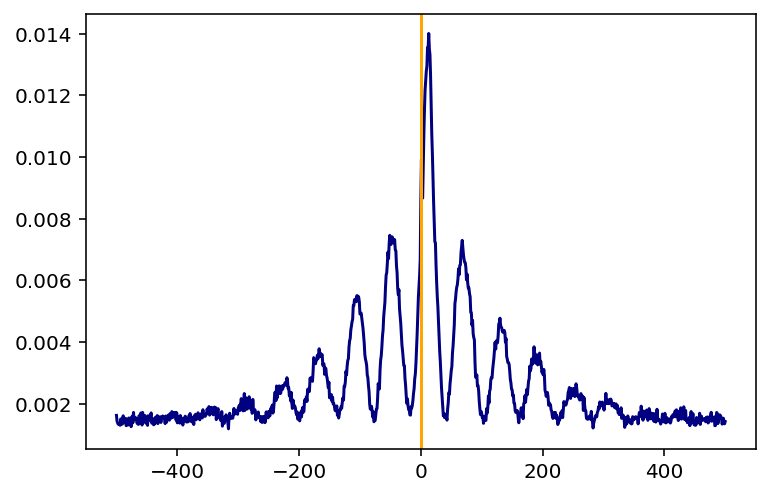

In [37]:
delay = np.arange(1001)-500
plt.plot(delay, tdmi(spike01, lfp_theta, delay), 'navy')
plt.axvline(0, color='orange')

In [38]:
# GC analysis
order = 30
print(f'GC lfp->spike : {GC(spike01, lfp_theta, order):.3e}')
print(f'GC spike->lfp : {GC(lfp_theta, spike01, order):.3e}')
print(f'GC threshold  : {GC_SI(0.001, order, len(lfp_theta)):.3e}')

GC lfp->spike : 1.699e-02
GC spike->lfp : 2.733e-02
GC threshold  : 5.970e-04


# End of the tutorial
---
